# Progetto di Big data in geographical information system
## Caricamento e manipolazione dei dati

Federico Luzzi - 816753

In [1]:
# Libraries
import warnings
warnings.filterwarnings('ignore')

import os

import numpy as np
import pandas as pd
import xarray as xr

import datetime as dtm
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Load CRUTEM4.6 data

In [2]:
crutem_path = r"D:\Data\geopy\CRUTEM.4.6.0.0.station_files"

flist = [os.path.join(path, name) for path, subdirs, 
         files in os.walk(crutem_path) for name in files]

# i primi 2 item non sono utili
flist=flist[2:]
nst = len(flist)
print (f"Number of stations = {nst}")

Number of stations = 10295


In [3]:
# definizione del dataframe metadata
metadata0 = pd.DataFrame(columns=['ID','stname','country','elev','lat','lon'])

# definizione dell'asse temporale sul quale saranno registrati i dati
taxis = pd.date_range('1850-01', '2019-01', freq='M')
nmonths=len(taxis)
nyears=nmonths/12

# definizione dataframe dove saranno salvate le temperature e location 
data0 = pd.DataFrame({'time': taxis})
data0 = data0.set_index(['time'])

In [4]:
# periodo di riferimento per calcolo anomalie
yref0 = 1961
yref1 = 1990

### Acquisizione del dataset

In [5]:
# I've inserted an try - except control because one file have a missing structure information

# counters per diagnostica
nodatacount=0  
tooshortcount=0 
outsidecount=0

from tqdm import tqdm
for si in tqdm(range(0, nst)):
    try:
        #- apertura file 
        filein=flist[si]

        #- Scan del file per trovare la line di inizio della matrice di dati ('Obs')
        #- controllo della presenza effettiva di dati
        
        with open(filein) as f: data = f.readlines()
        skipi = data.index("Obs:\n")+1
        if (len(data)-skipi < 2):
            nodatacount+=1    
            continue

        #- Estrarre quanti anni sono presenti per una certa stazione meteo 
        #- applicazione di alcuni filtri sulla lunghezza o timing della time series 
        #- come condizione per includere la stazione o meno 
        #- questa info si estrae direttamente dai dati   

        #- Nella prima colonna ho l'informazione degli anni
        yr = np.genfromtxt(filein, skip_header=skipi, delimiter=None, usecols=0, dtype='i4')
        nyr = len(yr)

        # se ho meno di 30 anni allora non la registro (troppo poco) 
        if (nyr < 30):
            tooshortcount+=1 
            continue  

        #- tenere solo le stazioni per le quali il calcolo medio del ciclo annuale per il periodo di riferimento 
        #- non è NAN per ogni mesee (ovvero no missing values)
       
        norm_line = [line for line in data if "Normals=" in line]
        norm = str(norm_line).split("=",1)[1]
        norm  = norm[:-4].strip() 
        if (norm.find("-99.0") > -1):   #se find = -1 non ha trovato none
            outsidecount+=1 
            continue   

        #- Se la stazione passa tutti i filtri viene caricata

        # Load metadata

        stname_line = [line for line in data if "Name=" in line]
        stname = str(stname_line).split("=",1)[1]
        stname  = stname[:-4].strip()    

        country_line = [line for line in data if "Country=" in line]
        country = str(country_line).split("=",1)[1]
        country  = country[:-4].strip()  # this removes spazi o a capo vari che possono causare problemi 

        elev_line = [line for line in data if "Height=" in line]
        elev = str(elev_line).split("=",1)[1] 
        elev = float(elev[:-4].strip())

        lat_line = [line for line in data if "Lat=" in line]
        lat = str(lat_line).split("=",1)[1] 
        lat = float(lat[:-4].strip())

        lon_line = [line for line in data if "Long=" in line]
        lon = str(lon_line).split("=",1)[1] 
        lon = float(lon[:-4].strip())      

        # Carichiamo tutti nel dataframe

        metadata0 = metadata0.append({
         "ID": filein[-6:],
         "stname": stname,
         "country": country,
         "elev": elev,
         "lat":  lat,      
         "lon":  lon,
         }, ignore_index=True)


        # Carichiamo i dati delle temperature

        # Dal TEMPLATE ...  
        # ...
        # Obs:
        # 1961   3.9   7.1   7.5  10.3  11.0  14.7  15.9  16.1  15.7  10.9   6.4   2.7   501   501   501   501   
        # 1962   4.1   4.5   2.5   7.6   9.8  13.0  15.1  14.7  12.6  10.5   5.9   1.7   501   501   501   501   
        
        #- Riorganiziamo i dati da 2D a 1D, associando ciascuna temperatura al datetime index
        #- Si costruisce un df 2D (time, station) in cui si potrà applicare altri filtri o groupby

        #- costruzione di un time axis locale
        # yr: la colonna che contiene la lista degli anni

        ti0 = datetime.strptime(str(yr[0]), "%Y")
        ti1 = datetime.strptime(str(yr[nyr-1]+1), "%Y")
        stime = pd.date_range(ti0, ti1, freq='M')     
        if ((yr[nyr-1]-yr[0]+1) != len(yr)):  # controllo se i dati di ciascun anno hanno missing tra il primo e l'ultimo
            print('WARNING: station {} has missing years !'.format(metadata0.ID[si]))
        
        #- lettura della table 2D (lato sinistro con dati temperature) come numpy array in cui successivamente si può rendere 1D

        loc_data_2d = np.genfromtxt(filein, skip_header=skipi, filling_values='-99.0', delimiter=None, dtype='float')[:,1:13]
        loc_data_1d = loc_data_2d.flatten()

        #- costruzione del dataframe locale, con ID colonna la stazione

        xdf = pd.DataFrame({'time': stime, filein[-6:]: np.asarray(loc_data_1d)})
        xdf = xdf.set_index('time')

        #- merge con dataset globale tramite ID stazione

        data0 = pd.merge(data0, xdf, on='time', how='left')

    except:
        continue

100%|████████████████████████████████████████████████████████████████████████████| 10295/10295 [04:37<00:00, 37.15it/s]


In [6]:
print(nodatacount,' stazioni senza dati')
print(tooshortcount,' stazioni con troppi pochi dati')
print(outsidecount,' stazioni con troppi pochi dati nel periodo di riferimento')
print("{} [{}] stazioni valide acquisite".format(nst-nodatacount-tooshortcount-outsidecount,len(metadata0.ID)))

13  stazioni senza dati
2054  stazioni con troppi pochi dati
771  stazioni con troppi pochi dati nel periodo di riferimento
7457 [7456] stazioni valide acquisite


In [7]:
metadata0.head()

,ID,stname,country,elev,lat,lon
0,010050,ISFJORD RADIO,NORWAY,9.0,78.0,-14.2
1,010070,NY-ALESUND,NORWAY,8.0,78.9,-11.9
2,010080,Svalbard Lufthavn,NORWAY,28.0,78.3,-15.5
3,010100,ANDENES,NORWAY,-999.0,69.3,-16.2
4,010101,BORKENES,NORWAY,36.0,68.8,-16.2


In [8]:
data0.iloc[1800:1805,50:60]

,011521,011560,011600,011650,011670,011720,011940,011960,011970,011990
time,,,,,,,,,,
2000-01-31,NaN,1.1,0.6,NaN,-0.4,-0.7,-0.8,-2.3,-6.4,-13.2
2000-02-29,NaN,1.1,0.4,NaN,-0.6,-0.8,-2.1,-4.5,-7.0,-11.9
2000-03-31,NaN,-0.5,-0.5,NaN,-1.4,-1.8,-1.4,-2.9,-5.1,-9.1
2000-04-30,NaN,1.3,1.7,NaN,0.9,1.4,1.4,0.1,-1.8,-4.9
2000-05-31,NaN,7.2,6.9,NaN,6.9,7.8,7.7,7.0,6.2,2.4


In [9]:
# Conversione di tutti i missing (-99.0) in NAN 
data0[data0 == -99.0] = np.nan

# setting dell'index dei metadata
metadata0 = metadata0.set_index(['ID'])

# Fix longitudes
metadata0.lon = -metadata0.lon

## Plot stations

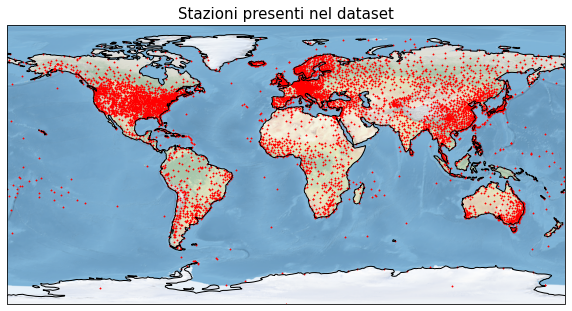

In [10]:
plt.subplots(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
ax.scatter([metadata0.lon],[metadata0.lat],color='r',marker='*',s=1)
plt.title("Stazioni presenti nel dataset", size=15)
plt.show()

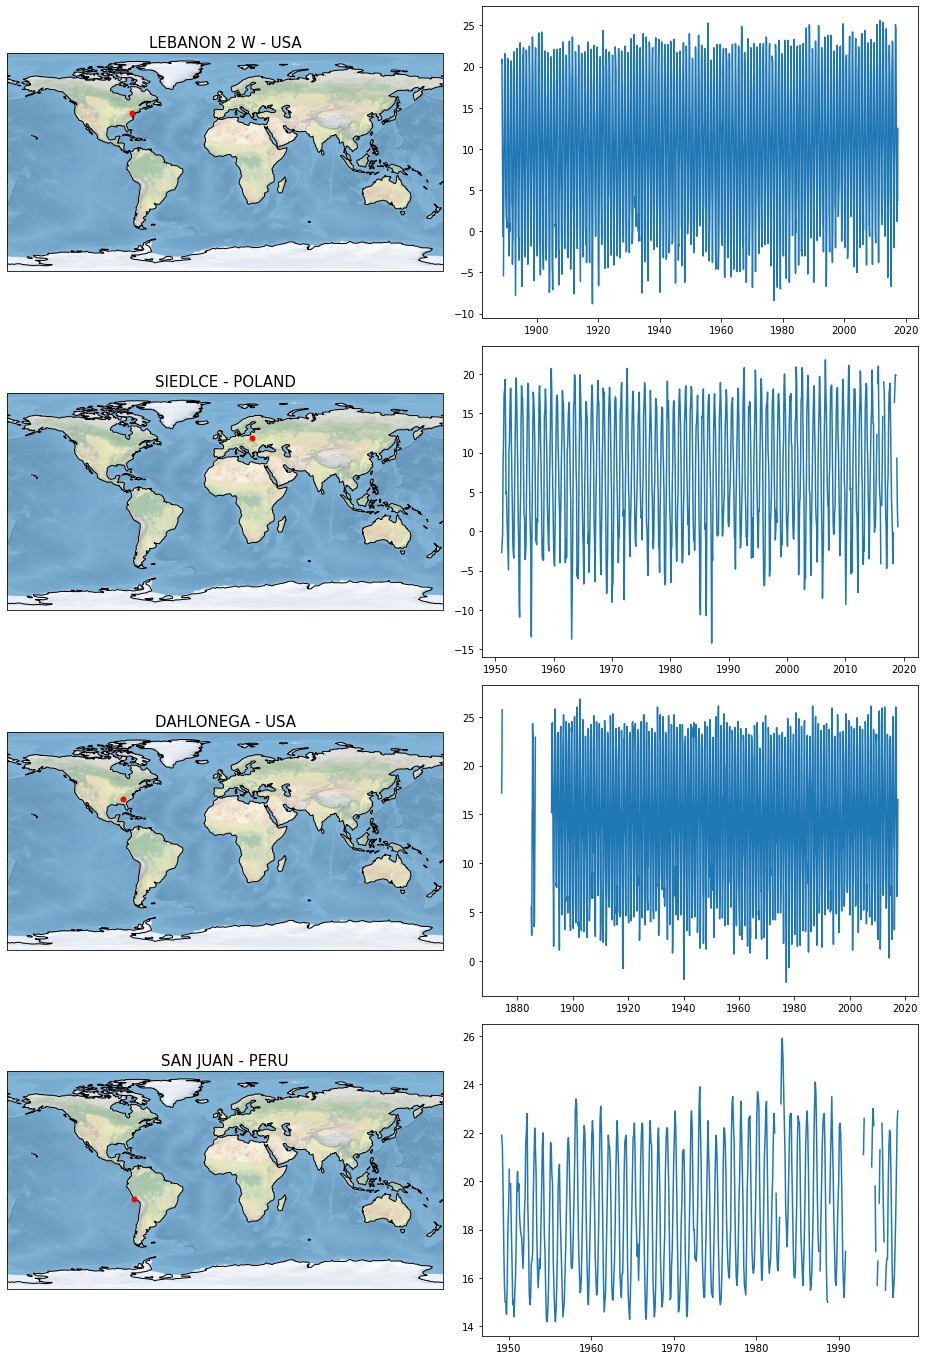

In [11]:
# Plot di alcune stazioni con relativa time series scelte randomicamente

#- Set multipanel plot
fig = plt.figure(figsize=(13,19))

no = 4   # numero di stazioni

subplots = (no,2)
n_panels = subplots[0] * subplots[1]

proj = ccrs.PlateCarree()

#- Selezione posti
rssite = np.random.randint(len(data0.columns), size=no)
ssite = metadata0.index[rssite]

for fi, f in enumerate(ssite):

    #- locazione nella mappa
    ax = fig.add_subplot(subplots[0], subplots[1], (fi*2)+1, projection=proj)
    ax.set_title(' - '.join([metadata0.stname[ssite[fi]],metadata0.country[ssite[fi]]]), size = 15)
    ax.stock_img()
    ax.coastlines()
    plt.plot(metadata0.lon[ssite[fi]], metadata0.lat[ssite[fi]],
         color='red', marker='o', markersize=5,
         transform=ccrs.Geodetic())         
 
    #- time series
    tser = fig.add_subplot(subplots[0], subplots[1], (fi+1)*2)
    #data0[ssite[fi]].plot()  
    plt.plot(data0[ssite[fi]])

fig.tight_layout()
plt.show()

## Anomalie

In [12]:
# identificazione del periodo di riferimento
x1=data0.index.get_loc('1961-01-31')
x2=data0.index.get_loc('1990-12-31')

# calcolo della temperatura normale (per mese)
data_normals = data0[x1:x2].groupby(data0[x1:x2].index.month).mean()

In [13]:
# sottraiamo la temperatura normale dalle time series originali per ottenere 
# le time series delle anomalie

data_anom = data0.copy()

# cicla attraverso tutti gli anni (ogni gennaio) 
# sottrare ad ogni chunk 12 i valori di temperatura normali

y0=0
for yi in range(0,int(nyears)):
    data_anom.iloc[y0:y0+12,:] = data0.iloc[y0:y0+12,:]-np.array(data_normals.iloc[:,:])
    y0+=12

## Regridding

In [14]:
# creazione griglia di 5 gradi

resol = 5  # gradi (E e N)
nlon = int(360/resol)
nlat = int(180/resol)

# definizione margini della griglia

grlons = np.empty([nlon+1],dtype='float') 
grlats = np.empty([nlat+1],dtype='float') 
grlons[0] = -180.
grlats[0] = -90.
for i in range(1,nlon+1):
    grlons[i]=grlons[i-1]+resol
for i in range(1,nlat+1):
    grlats[i]=grlats[i-1]+resol

In [15]:
# creazione struttura per contenere la griglia 3D

data_mo = np.empty([nmonths,nlat+1,nlon+1],dtype=float)
data_mo[:,:,:] = np.nan

data_or = np.empty([nmonths,nlat+1,nlon+1],dtype=float)
data_or[:,:,:] = np.nan

In [16]:
# A ciascuna iterazione delle celle:
# - calcolo media time series (mensili) di tutte le stazioni in quella griglia 
# sia delle anomalie che temperature originali

for j in range(0,nlat):
    for i in range(0,nlon):

        dummy = metadata0[metadata0.lon >= grlons[i]]
        dummy = dummy[dummy.lon < grlons[i+1]]
        dummy = dummy[dummy.lat >= grlats[j]]
        dummy = dummy[dummy.lat < grlats[j+1]]

        #print('*',grlons[i],grlons[i+1],grlats[j],grlats[j+1])
        #print(dummy.index)

        if (len(dummy.index) > 0):
            data_mo[:,j,i] = np.array(data_anom[dummy.index].mean(axis=1)).flatten()
            data_or[:,j,i] = np.array(data0[dummy.index].mean(axis=1)).flatten()

In [17]:
print(data_mo.shape)
print(data_or.shape)

(2028, 37, 73)
(2028, 37, 73)


Creazione di xArray per comodità di gestione dei dati

In [18]:
print(f"temperature size: {data_mo.shape}")
print(f"time axis size: {taxis.shape}")
print(f"latitude size: {grlats.shape}")
print(f"logitude size: {grlons.shape}")

temperature size: (2028, 37, 73)
time axis size: (2028,)
latitude size: (37,)
logitude size: (73,)


In [19]:
# anomalie (xarray)
crut_anom = xr.Dataset(
    data_vars=dict(
        temp=(["time", "lat", "lon"], data_mo),
    ),
    coords=dict(
        time=taxis,
        lat=(grlats),
        lon=(grlons)
    ),
    attrs=dict(description="Temperature related data"),
)

# temperature originali (xarray)
crut_or = xr.Dataset(
    data_vars=dict(
        temp=(["time", "lat", "lon"], data_or),
    ),
    coords=dict(
        time=taxis,
        lat=(grlats),
        lon=(grlons)
    ),
    attrs=dict(description="Temperature related data"),
)
crut_or

<xarray.Dataset>
Dimensions:  (lat: 37, lon: 73, time: 2028)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2018-12-31
  * lat      (lat) float64 -90.0 -85.0 -80.0 -75.0 -70.0 ... 75.0 80.0 85.0 90.0
  * lon      (lon) float64 -180.0 -175.0 -170.0 -165.0 ... 170.0 175.0 180.0
Data variables:
    temp     (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    description:  Temperature related data

In [20]:
temp_or = crut_or.temp
temp_or_m = temp_or.mean(axis=0) # temperature medie per latitudine e longitudine

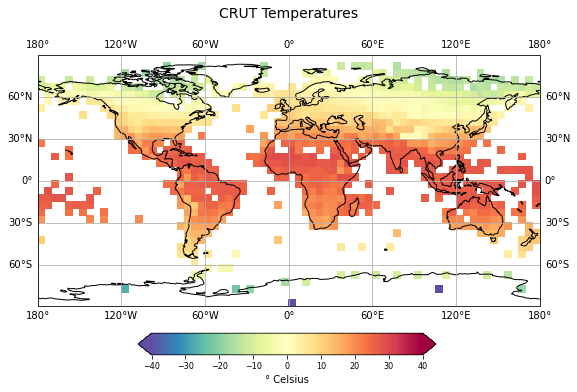

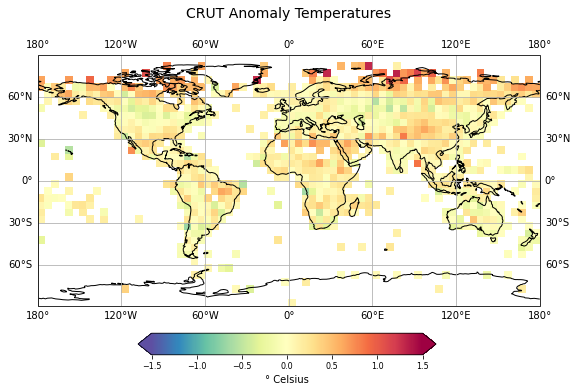

In [21]:
#- add cyclic point form plotting purposes
from cartopy.util import add_cyclic_point
ts_avg_cyc, lon_cyc = add_cyclic_point(temp_or_m, coord=crut_or.lon) 
norm = mpl.colors.Normalize(vmin=-40, vmax=40) 

fig = plt.figure(figsize=(9,6)) 

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title('CRUT Temperatures\n', size = 14)
ax.set_global()
mm = ax.pcolormesh(lon_cyc, crut_or.lat, temp_or_m, \
                   transform=ccrs.PlateCarree(),
                   cmap=mpl.cm.Spectral_r,
                   norm = norm)  

ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46, 0.05]) #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('° Celsius')
cbar.ax.tick_params(labelsize=8)

plt.show()


norm = mpl.colors.Normalize(vmin=-1.5, vmax=1.5) 
fig = plt.figure(figsize=(9,6)) 

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title('CRUT Anomaly Temperatures\n', size = 14)
ax.set_global()
mm = ax.pcolormesh(lon_cyc, crut_anom.lat, crut_anom.temp.mean(axis=0), \
                   transform=ccrs.PlateCarree(),
                   cmap=mpl.cm.Spectral_r,
                   norm = norm)  

ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46, 0.05]) #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('° Celsius')
cbar.ax.tick_params(labelsize=8)

plt.show()

Si può notare che la distribuzione delle stazioni meteo selezionate sono dell'entroterra, in particolare nelle zone più abitate o sede di centri di ricerca come in antartide.

In [22]:
crut_temp_or = crut_or.mean(dim=['lat','lon']).resample(time='1M').mean().temp
crut_temp_anom = crut_anom.mean(dim=['lat','lon']).resample(time='1M').mean().temp

### Plot della serie storica delle medie temperature e anomalie

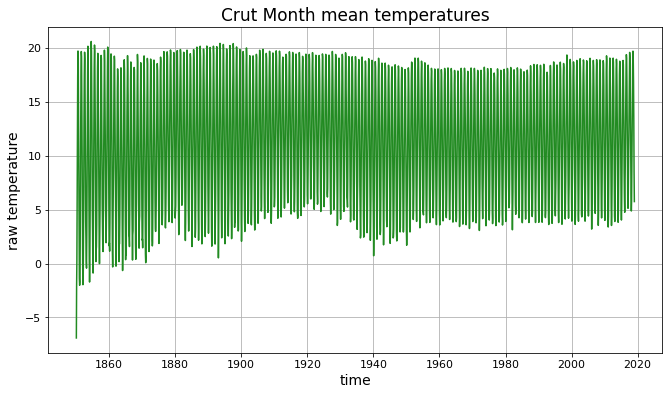

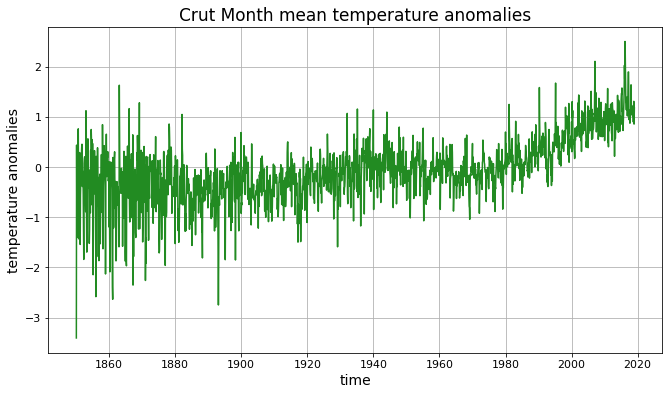

In [25]:
plt.figure(figsize = (11,6))
plt.plot(crut_or.time, crut_temp_or, color = "forestgreen")

plt.title("Crut Month mean temperatures", size = 17)
plt.xlabel("time", size = 14)
plt.ylabel("raw temperature", size = 14)
plt.xticks(size = 11)
plt.yticks(size = 11)
plt.grid()

plt.figure(figsize = (11,6))
plt.plot(crut_or.time, crut_temp_anom, color = "forestgreen")

plt.title("Crut Month mean temperature anomalies", size = 17)
plt.xlabel("time", size = 14)
plt.ylabel("temperature anomalies", size = 14)
plt.xticks(size = 11)
plt.yticks(size = 11)

plt.grid()

### Salvataggio dati

In [46]:
gmta = pd.DataFrame({'time': pd.date_range('1850-01', '2019-01', freq='M')})
gmta['value'] = crut_temp_anom
gmta = gmta.set_index(['time'])

gmta.to_csv('_'.join(['models/crut4',str(int(nst-nodatacount-tooshortcount-outsidecount)),'ts.csv']))

In [47]:
crut_anom.to_netcdf("models/crut.nc")

---
---
---

# IPSL Model
## Load and import models

In [32]:
cmip6_path = r'D:\Data\geopy\CMIP6_data'

In [33]:
dd = xr.open_dataset(f'{cmip6_path}/ts_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc')

In [34]:
dd

<xarray.Dataset>
Dimensions:      (axis_nbounds: 2, lat: 143, lon: 144, time: 1980)
Coordinates:
  * lat          (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:...
Dimensions without coordinates: axis_nbounds
Data variables:
    time_bounds  (time, axis_nbounds) datetime64[ns] ...
    ts           (time, lat, lon) float32 ...
Attributes: (12/51)
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-07-11T07:36:33Z
    tracking_id:            hdl:21.14100/3168f5b1-bf0a-4aec-931f-73c9d0034a45
    description:            CMIP6 historical
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / CM...
    activity_id:            CMIP
    ...                     ...
    name:                   /ccc/work/cont003/gencmip6/p86caub/IGCM_OUT/IPSLC...
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.IPSL.IPSL-CM...
    variant_label:          r1i1p1f1
    realization_index:      1
    history:                Sat Dec  1 12:17:27 2018: ncatted -O -a realizati...
    NCO:                    "4.6.0"

In [35]:
# estrazione info temperatura
ipsl = dd.ts
print(ipsl.shape)

(1980, 143, 144)


### Regridding
Effettuo un **Regridding** per poter confrontare graficamente il modello IPSL con i dati raw. Il procedimento è stato effettuato tramite metodo ``nearest``

In [36]:
ipsl_r = ipsl.interp(lat=grlats, lon=grlons+180, method='nearest')
print(ipsl_r.shape)

(1980, 37, 73)


In [37]:
ipsl_m = ipsl_r.mean(axis=0) - 273.15
ipsl_m = ipsl_m.assign_coords(lon=(ipsl_m.lon - 180)) # fix coordinate

## Plot del modello IPSL

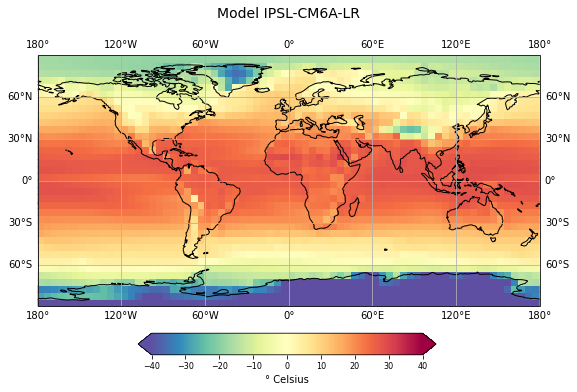

In [38]:
#- add cyclic point form plotting purposes
from cartopy.util import add_cyclic_point
_, lon_cyc = add_cyclic_point(ipsl_r.mean(axis=0)-273.15, coord=ipsl_r.lon)  # also Kelvin to Celsius
norm = mpl.colors.Normalize(vmin=-40, vmax=40) 

# Model IPSL-CM6A-LR
fig = plt.figure(figsize=(9,6))  

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title('Model IPSL-CM6A-LR\n', size = 14)
ax.set_global()
mm = ax.pcolormesh(lon_cyc, ipsl_r.lat, ipsl_m, \
                   transform=ccrs.PlateCarree(),
                   cmap=mpl.cm.Spectral_r,
                   norm = norm, shading='auto')  

ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46, 0.05]) #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('° Celsius')
cbar.ax.tick_params(labelsize=8)

plt.show()

## IPSL time series & anomalies

Per l'interpolazione da mappa 2D a serie storica andiamo a creare una mappa di pesi per dare meno importanza agli estremi della mappa (poli) in quanto meno ampie spazialmente parlando rispetto alle aree equatoriali.

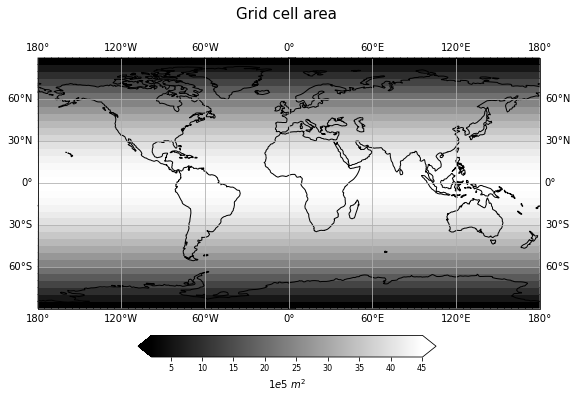

In [39]:
area = np.empty([len(ipsl_r.lat),len(ipsl_r.lon)],dtype=float)

er = 6371 # km
from math import sin,radians,pi

for j in range(0,len(ipsl_r.lat)-1):
    area[j,:]= 2*pi*(er**2) * abs(sin(radians(ipsl_r.lat[j]))-sin(radians(ipsl_r.lat[j+1]))) * len(ipsl_r.lon)/360

area[-1,:]=area[0,:]
    
fig = plt.figure(figsize=(9,6))  # x,y(inches)

tmax = 40
#norm = mpl.colors.Normalize(vmin=-tmax,vmax=tmax) 

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title(' '.join(['Grid cell area','\n']), fontsize = 15)
ax.set_global()
mm = ax.pcolormesh(lon_cyc, ipsl_r.lat, area/1e5, \
                   transform=ccrs.PlateCarree(), cmap=mpl.cm.gist_gray)  
ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46, 0.05]) #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('$1e5$ $m^{2}$')
cbar.ax.tick_params(labelsize=8)

plt.show()
plt.close()

Quindi si da più peso alle aree più ampie (tendente al bianco), rispetto alle aree meno estese (tendente al nero)

Creazione della time series media pesata

In [40]:
ipsl_temp_lats = np.average(ipsl_r, weights=area[:,0], axis=1)

ipsl_temp_series = np.nanmean(ipsl_temp_lats,axis=1) 
print(np.shape(ipsl_temp_series))

(1980,)


In [41]:
ipsl_df = pd.DataFrame({'time': pd.date_range('1850-01', '2015-01', freq='M')})
ipsl_df['value'] = ipsl_temp_series
ipsl_df = ipsl_df.set_index(['time'])
ipsl_df['mese'] = ipsl_df.index.month

## Calcolo anomalie
Calcolo delle anomalie è stato fatto mensilmente prendendo lo stesso periodo di riferimento del caso precedente 1961-1990

In [42]:
ipsl_df_normals = ipsl_df.loc['1961':'1990'].groupby('mese').mean()
ipsl_df_normals

,value
mese,
1,285.661915
2,285.972004
3,286.607508
4,287.378130
5,288.030724
6,288.717098
7,289.110286
8,289.054517
9,288.383790


In [43]:
ipsl_df = ipsl_df.merge(ipsl_df_normals, left_on='mese', right_index=True, suffixes=["_temp", "_norm"])
ipsl_df['value'] = ipsl_df['value_temp'] - ipsl_df['value_norm']
ipsl_df.drop(columns=['mese', 'value_temp', 'value_norm'], inplace=True)
ipsl_df.sort_index(inplace=True)
ipsl_df.head()

,value
time,
1850-01-31,-0.882162
1850-02-28,-0.768894
1850-03-31,-0.796424
1850-04-30,-0.784580
1850-05-31,-0.680309


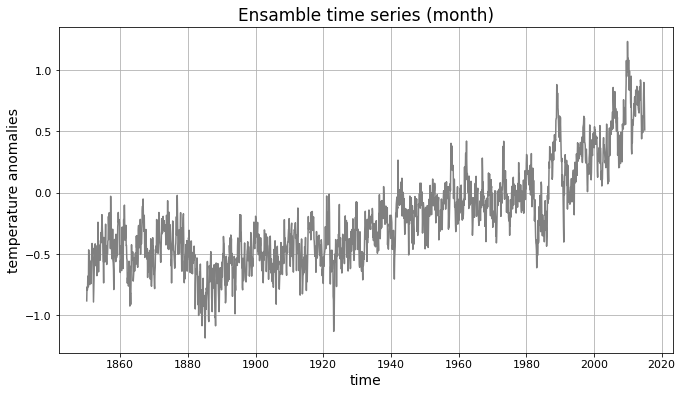

In [44]:
plt.figure(figsize = (11,6))
plt.plot(ipsl_df.index, ipsl_df.value, color = "gray")

plt.title("Ensamble time series (month)", size = 17)
plt.xlabel("time", size = 14)
plt.ylabel("temperature anomalies", size = 14)
plt.xticks(size = 11)
plt.yticks(size = 11)

plt.grid()

Salvataggio time series anomalie dell'ensamble model

In [45]:
ipsl_df.to_csv('models/ipsl_ts.csv')